In [1]:
import pandas as pd
df_blocks = pd.read_csv("df_blocks.csv")

In [2]:
df_blocks.head()

,type,content,article_id
0,theorem,The approximate peak time for a small fluoresc...,2502.01037
1,theorem,The approximate peak time for a large fluoresc...,2502.01037
2,definition,We define approximate peak time $t^{p}_0$ by t...,2502.01037
3,definition,Assume \eqref{ellcondition1} and \eqref{ellcon...,2502.01037
4,proof,We first study the asymptotic behavior of the ...,2502.01037


In [3]:
from sklearn.model_selection import train_test_split

# Llista única d'articles
article_ids = df_blocks["article_id"].unique()

# Divisió estratificada si vols (per mida o nombre de blocs), o aleatòria
train_articles, test_articles = train_test_split(article_ids, test_size=0.2, random_state=42)

# Separem els blocs
df_train = df_blocks[df_blocks["article_id"].isin(train_articles)]
df_test = df_blocks[df_blocks["article_id"].isin(test_articles)]


In [10]:
from itertools import combinations
import pandas as pd

def generar_parejas(df,column):
    parejas = []

    # Agrupar per article i tipus
    for (article_id, tipo), sub_df in df.groupby(["article_id", "type"]):
        for a, b in combinations(sub_df[column], 2):
            parejas.append((a, b, 1))

    return pd.DataFrame(parejas, columns=["text_a", "text_b", "label"])


In [11]:
from itertools import product
import pandas as pd
import random

def generar_parejas_negativas_fortes(df, num_positives, column, ratio=2, seed=42):
    random.seed(seed)
    negatives = []

    # Generar totes les parelles negatives candidates
    for a1 in df["article_id"].unique():
        for a2 in df["article_id"].unique():
            if a1 == a2:
                continue
            df1 = df[df["article_id"] == a1]
            df2 = df[df["article_id"] == a2]

            for t1 in df1["type"].unique():
                for t2 in df2["type"].unique():
                    if t1 == t2:
                        continue
                    sub1 = df1[df1["type"] == t1]
                    sub2 = df2[df2["type"] == t2]
                    for x, y in product(sub1[column], sub2[column]):
                        negatives.append((x, y, 0))

    # Barrejar i reduir segons la proporció
    random.shuffle(negatives)
    num_negatives = min(len(negatives), num_positives * ratio)
    sampled_negatives = negatives[:num_negatives]

    return pd.DataFrame(sampled_negatives, columns=["text_a", "text_b", "label"])


In [13]:
parelles_positives_train =  generar_parejas(df_train, column = "content")
parelles_negatives_train = generar_parejas_negativas_fortes(df_train, num_positives=len(parelles_positives_train), ratio=2, column = "content")  # negatives fortes: tipus diferent i article diferent
df_parelles_train = pd.concat([parelles_positives_train, parelles_negatives_train], ignore_index=True)


In [14]:
parelles_positives_test =  generar_parejas(df_test, column = "content")
parelles_negatives_test = generar_parejas_negativas_fortes(df_test, num_positives=len(parelles_positives_test), ratio=2, column = "content")  # negatives fortes: tipus diferent i article diferent
df_parelles_test = pd.concat([parelles_positives_test, parelles_negatives_test], ignore_index=True)

In [15]:
print(df_parelles_train.shape, df_parelles_test.shape)

(25044, 3) (8229, 3)


In [21]:
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Model i loss
model = SentenceTransformer("nomic-ai/modernbert-embed-base")
model.max_seq_length = 512  # no més
model.to(device)
train_loss = losses.ContrastiveLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE)

# === Dataloader amb collate
# Converteix el df a InputExample
train_examples = [
    InputExample(texts=[row["text_a"], row["text_b"]], label=float(row["label"]))
    for _, row in df_parelles_train.iterrows()
]

# DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2, collate_fn=model.smart_batching_collate)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# === Entrenament manual
model.train()
for epoch in range(3):
    total_loss = 0
    for features, labels in tqdm(train_dataloader, desc="Training"):
        # Moure cada diccionari de la llista a GPU
        features = [{k: v.to(device) for k, v in feature.items()} for feature in features]
        labels = labels.to(device)

        optimizer.zero_grad()
        loss = train_loss(features, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        del features, labels, loss
        torch.cuda.empty_cache()

    print(f"Epoch completed. Loss: {total_loss:.4f}")

# === Guarda el model
model.save("output/modernbert-contrastive-manual-data_divided")


Training: 100%|██████████| 12522/12522 [10:36:41<00:00,  3.05s/it] 


Epoch completed. Loss: 33.4981


Training: 100%|██████████| 12522/12522 [4:48:48<00:00,  1.38s/it]  


Epoch completed. Loss: 7.6213


Training: 100%|██████████| 12522/12522 [4:29:23<00:00,  1.29s/it]  


Epoch completed. Loss: 3.7817


In [23]:
from sklearn.metrics import roc_auc_score, accuracy_score
from torch.nn.functional import cosine_similarity
import numpy as np

model.eval()

emb1_list = []
emb2_list = []
y_true = []
y_scores = []

test_examples = [
    InputExample(texts=[row["text_a"], row["text_b"]], label=float(row["label"]))
    for _, row in df_parelles_test.iterrows()
]

with torch.no_grad():
    for example in tqdm(test_examples, desc="Testing"):
        emb1 = model.encode(example.texts[0], convert_to_tensor=True, device=device)
        emb2 = model.encode(example.texts[1], convert_to_tensor=True, device=device)
        sim = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

        emb1_list.append(emb1.cpu().numpy())
        emb2_list.append(emb2.cpu().numpy())
        y_true.append(example.label)
        y_scores.append(sim)

# === Mètriques
auc = roc_auc_score(y_true, y_scores)
acc = accuracy_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])

print(f"AUC: {auc:.4f}")
print(f"Accuracy (umbral 0.5): {acc:.4f}")


Testing: 100%|██████████| 8229/8229 [11:38<00:00, 11.77it/s]

AUC: 0.9592
Accuracy (umbral 0.5): 0.8807


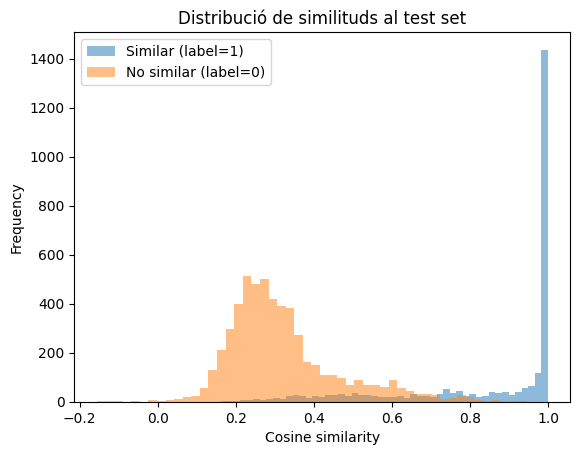

In [24]:
import matplotlib.pyplot as plt

plt.hist([s for s, y in zip(y_scores, y_true) if y == 1], bins=50, alpha=0.5, label="Similar (label=1)")
plt.hist([s for s, y in zip(y_scores, y_true) if y == 0], bins=50, alpha=0.5, label="No similar (label=0)")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribució de similituds al test set")
plt.show()


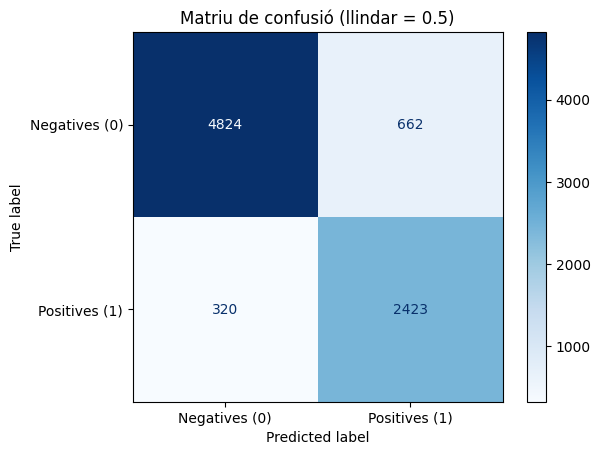

🔢 Valors:
TN (negatives correctes): 4824
FP (falsos positius):     662
FN (falsos negatius):     320
TP (positives correctes): 2423


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ───────────────────────────────────────────────────
# Tria un llindar per fer classificació binària
llindar = 0.5  # ajustable

# Generem prediccions: si similitud > llindar → positiva
prediccions = [1 if s >= llindar else 0 for s in y_scores]

# ───────────────────────────────────────────────────
# Matriu de confusió
cm = confusion_matrix(y_true, prediccions)
labels = ["Negatives (0)", "Positives (1)"]

# Mostrem matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title(f"Matriu de confusió (llindar = {llindar})")
plt.show()

# També mostrem les xifres
tn, fp, fn, tp = cm.ravel()
print("🔢 Valors:")
print(f"TN (negatives correctes): {tn}")
print(f"FP (falsos positius):     {fp}")
print(f"FN (falsos negatius):     {fn}")
print(f"TP (positives correctes): {tp}")


In [26]:
from sklearn.metrics import f1_score

# Prova diversos llindars
thresholds = np.linspace(0, 1, 100)
f1s = [f1_score(y_true, [1 if s >= t else 0 for s in y_scores]) for t in thresholds]

# Troba el millor llindar
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Millor llindar segons F1-score: {best_threshold:.2f} (F1 = {f1s[best_idx]:.4f})")


Millor llindar segons F1-score: 0.65 (F1 = 0.8593)


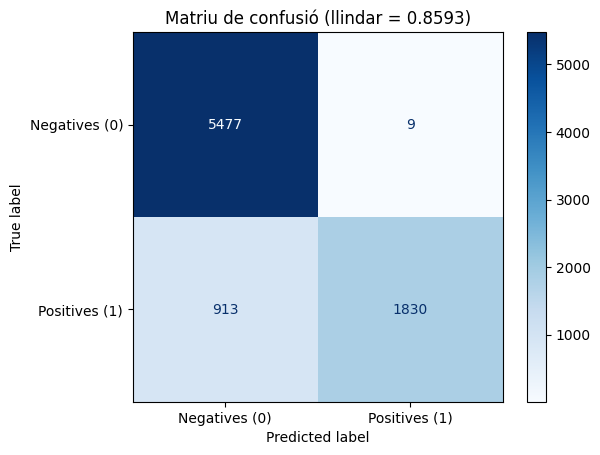

🔢 Valors:
TN (negatives correctes): 5477
FP (falsos positius):     9
FN (falsos negatius):     913
TP (positives correctes): 1830


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ───────────────────────────────────────────────────
# Tria un llindar per fer classificació binària
llindar = 0.8593  # ajustable

# Generem prediccions: si similitud > llindar → positiva
prediccions = [1 if s >= llindar else 0 for s in y_scores]

# ───────────────────────────────────────────────────
# Matriu de confusió
cm = confusion_matrix(y_true, prediccions)
labels = ["Negatives (0)", "Positives (1)"]

# Mostrem matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title(f"Matriu de confusió (llindar = {llindar})")
plt.show()

# També mostrem les xifres
tn, fp, fn, tp = cm.ravel()
print("🔢 Valors:")
print(f"TN (negatives correctes): {tn}")
print(f"FP (falsos positius):     {fp}")
print(f"FN (falsos negatius):     {fn}")
print(f"TP (positives correctes): {tp}")


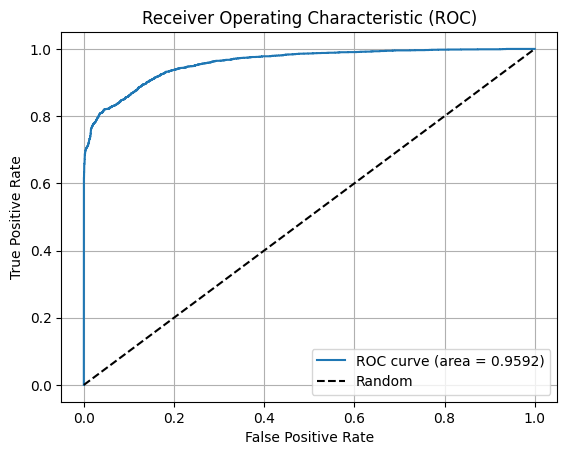

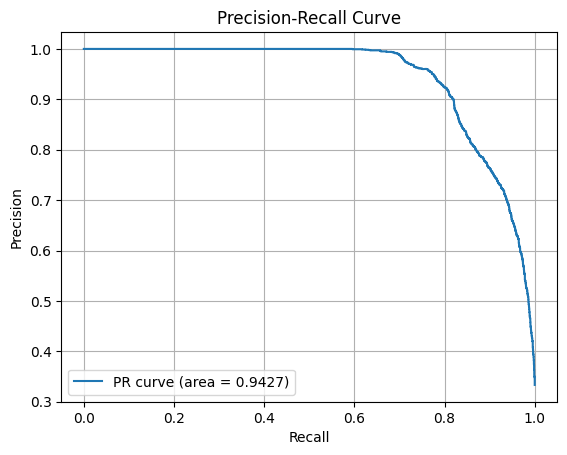

In [28]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR curve (area = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()
